In [1]:
%load_ext autoreload
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%autoreload
from dmaker.environment import DecisionEnvironment, DecisionEnvironmentGrid
from dmaker.decision_maker import DynamicDecisionMaker, FixedDecisionMaker

In [3]:
Ns = [10, 20, 50, 100]
cs = [0.1, 0.2, 0.5, 1, 5, 10]
sigmas = [0.5, 1, 3, 5, 7, 10, 50, 100]
taus = [0.5, 1, 3]

num_trials = 100

data = pd.DataFrame()

for N in Ns:
    decision_makers = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40, 50, 100]
    decision_makers = list(filter(lambda x: x <= N, decision_makers))
    print("N", N)
    for c in cs:
        print("c", c)
        for sigma in sigmas:
            for tau in taus:
                env = DecisionEnvironment(N=N, num_trials=num_trials, sigma=sigma, tau=tau)
                ddm = DynamicDecisionMaker(env, cost_eval=c)
                ddm.decide()
                
                temp_data = ddm.data
                temp_data["agent"] = "dynamic"
                
                fixed_dm = [FixedDecisionMaker(env, i, cost_eval=c) for i in decision_makers]
                for dm in fixed_dm:
                    dm.decide()
                    dm.data["agent"] = dm.name
                    temp_data = temp_data.append(dm.data)
                
                temp_data["N"] = N
                temp_data["c"] = c
                temp_data["sigma"] = sigma
                temp_data["tau"] = tau
                
                data = data.append(temp_data)

N 10
c 0.1
c 0.2
c 0.5
c 1
N 20
c 0.1
c 0.2
c 0.5
c 1
N 50
c 0.1
c 0.2
c 0.5
c 1
N 100
c 0.1
c 0.2
c 0.5
c 1


In [126]:
data = data.astype({"num_eval": "int64", "utility": "float64", "utility_second_best": "float64",
 "gross_utility_last_eval": "float64", "V_index": "int64", "Vhat_index": "int64", "N": "int64", "c": "float64",
 "sigma": "float64", "tau": "float64"
})
data["rho"] = data["tau"]**2/((data["tau"]**2+data["sigma"]**2)**(1/2)*data["tau"])

In [181]:
#data.to_csv("results_final_feb21_2.csv")
data = pd.read_csv("results_final_feb21_2.csv").drop(columns=["Unnamed: 0"])

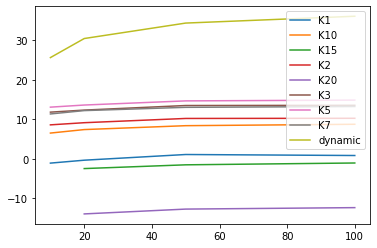

In [182]:
# Across N
toplot = data.groupby(by=["agent", "N"]).agg({"utility": "mean"}).reset_index()
toplot = toplot[(toplot["agent"]!="K100")&(toplot["agent"]!="K50")&(toplot["agent"]!="K40")&(toplot["agent"]!="K30")]

for agent in toplot["agent"].unique():
    subset = toplot[toplot["agent"]==agent]
    plt.plot(subset["N"], subset["utility"], label=agent)

plt.legend()
plt.show()

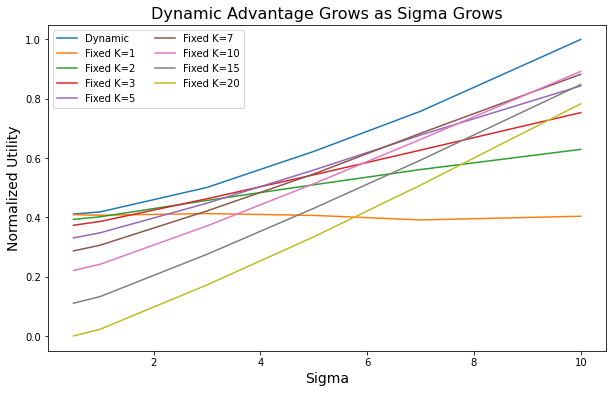

In [216]:
# Across sigma, normalized globally
toplot = data[(data["N"]==20)&(data["c"]<=1)&(data["sigma"]<50)].groupby(by=["agent", "sigma"]).agg({"utility": "mean"}).reset_index()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

toplot["utility"] += min(toplot["utility"]) * ((min(toplot["utility"]) <= 0)  * (-1))
toplot["utility"] /= max(toplot["utility"])

def agent_to_numeric(agent):
    return 

toplot = toplot.assign(agent_numeric=toplot["agent"].apply(lambda x: x.title() if x == "dynamic" else int(x[1:])))

for agent in sorted(toplot["agent_numeric"].unique(), key=lambda x: -100 if type(x)==str else x):
    subset = toplot[toplot["agent_numeric"]==agent]
    plt.plot(subset["sigma"], subset["utility"], label=f"Fixed K={agent}" if type(agent)==int else agent)

plt.ylabel("Normalized Utility", size=14)
plt.xlabel("Sigma", size=14)
plt.legend(ncol=2)
plt.title("Dynamic Advantage Grows as Sigma Grows", size=16)
plt.show()

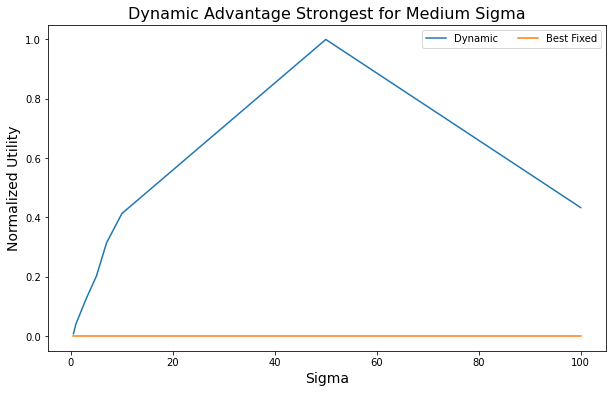

In [214]:
# Across sigma for best fixed only, normalized
toplot = data[(data["N"]==50)&(data["c"]<=1)].groupby(by=["agent", "sigma"]).agg({"utility": "mean"}).reset_index()

best_fixed = toplot[toplot["agent"]!="dynamic"].groupby("sigma").agg({"utility": "max"}).reset_index()
best_fixed["agent"] = "best fixed"
toplot = toplot.append(best_fixed)
toplot = toplot[(toplot["agent"]=="best fixed")|(toplot["agent"]=="dynamic")]

# Take out absolute amount for each
toplot = toplot.sort_values(["agent", "sigma"])
toplot.loc[toplot["agent"]=="dynamic", "utility"] = toplot.loc[toplot["agent"]=="dynamic", "utility"].values - toplot.loc[toplot["agent"]=="best fixed", "utility"].values
toplot.loc[toplot["agent"]=="best fixed", "utility"] = toplot.loc[toplot["agent"]=="best fixed", "utility"].values - toplot.loc[toplot["agent"]=="best fixed", "utility"].values

# and then stretch each dynamic so that it is at 1 at the max
toplot["utility"] /= max(toplot["utility"])

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

for agent in ["dynamic", "best fixed"]:
    subset = toplot[toplot["agent"]==agent]
    plt.plot(subset["sigma"], subset["utility"], label=agent.title())

plt.ylabel("Normalized Utility", size=14)
plt.xlabel("Sigma", size=14)
plt.legend(ncol=2)
plt.title("Dynamic Advantage Strongest for Medium Sigma", size=16)
plt.show()

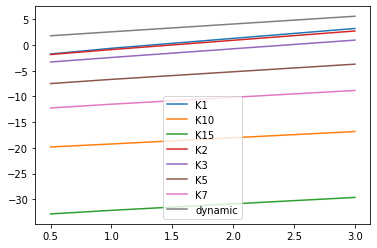

In [157]:
# Across tau
toplot = data[data["sigma"]==5].groupby(by=["agent", "tau"]).agg({"utility": "mean"}).reset_index()
toplot = toplot[(toplot["agent"]!="K100")&(toplot["agent"]!="K50")&(toplot["agent"]!="K40")&(toplot["agent"]!="K30")&(toplot["agent"]!="K20")]

for agent in toplot["agent"].unique():
    subset = toplot[toplot["agent"]==agent]
    plt.plot(subset["tau"], subset["utility"], label=agent)

plt.legend()
plt.show()

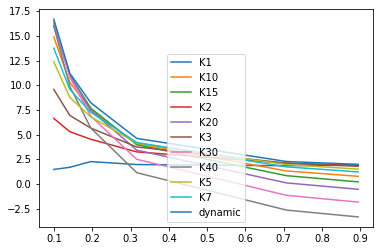

In [169]:
# Across rho
toplot = data[(data["tau"]==1)&(data["sigma"]<50)&(data["c"]<=0.2)].groupby(by=["agent", "rho"]).agg({"utility": "mean"}).reset_index()
toplot = toplot[(toplot["agent"]!="K100")&(toplot["agent"]!="K50")]

for agent in toplot["agent"].unique():
    subset = toplot[toplot["agent"]==agent]
    plt.plot(subset["rho"], subset["utility"], label=agent)

plt.legend()
plt.show()

In [125]:
"""Ns = [10, 20, 50, 100]
cs = [5, 10]
sigmas = [0.5, 1, 3, 5, 7, 10, 50, 100]
taus = [0.5, 1, 3]

num_trials = 100

for N in Ns:
    decision_makers = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40, 50, 100]
    decision_makers = list(filter(lambda x: x <= N, decision_makers))
    print("N", N)
    for c in cs:
        print("c", c)
        for sigma in sigmas:
            for tau in taus:
                env = DecisionEnvironment(N=N, num_trials=num_trials, sigma=sigma, tau=tau)
                ddm = DynamicDecisionMaker(env, cost_eval=c)
                ddm.decide()
                
                temp_data = ddm.data
                temp_data["agent"] = "dynamic"
                
                fixed_dm = [FixedDecisionMaker(env, i, cost_eval=c) for i in decision_makers]
                for dm in fixed_dm:
                    dm.decide()
                    dm.data["agent"] = dm.name
                    temp_data = temp_data.append(dm.data)
                
                temp_data["N"] = N
                temp_data["c"] = c
                temp_data["sigma"] = sigma
                temp_data["tau"] = tau
                
                data = data.append(temp_data)
"""

N 10
c 5
c 10
N 20
c 5
c 10
N 50
c 5
c 10
N 100
c 5
c 10


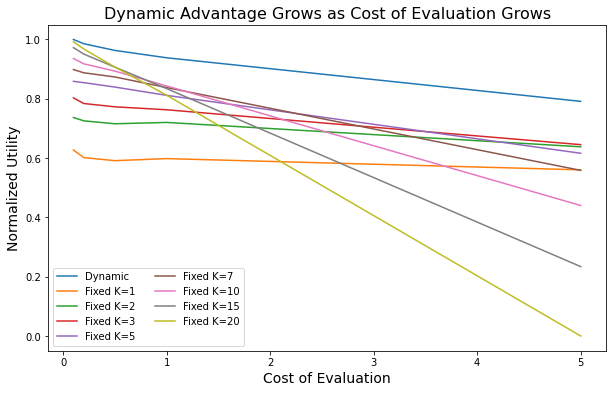

In [219]:
# Across sigma, normalized globally
toplot = data[(data["N"]==20)&(data["c"]<=5)].groupby(by=["agent", "c"]).agg({"utility": "mean"}).reset_index()
toplot = toplot[(toplot["agent"]!="K100")]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

toplot["utility"] += min(toplot["utility"]) * ((min(toplot["utility"]) <= 0)  * (-1))
toplot["utility"] /= max(toplot["utility"])

def agent_to_numeric(agent):
    return 

toplot = toplot.assign(agent_numeric=toplot["agent"].apply(lambda x: x.title() if x == "dynamic" else int(x[1:])))

for agent in sorted(toplot["agent_numeric"].unique(), key=lambda x: -100 if type(x)==str else x):
    subset = toplot[toplot["agent_numeric"]==agent]
    plt.plot(subset["c"], subset["utility"], label=f"Fixed K={agent}" if type(agent)==int else agent)

plt.ylabel("Normalized Utility", size=14)
plt.xlabel("Cost of Evaluation", size=14)
plt.legend(ncol=2)
plt.title("Dynamic Advantage Grows as Cost of Evaluation Grows", size=16)
plt.show()

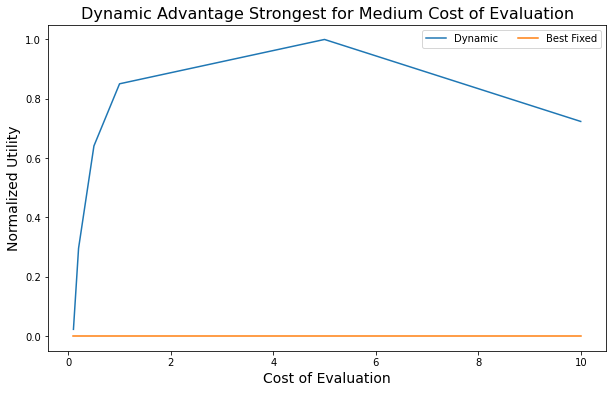

In [225]:
# Across c for best fixed only, normalized
toplot = data[(data["sigma"]<=50)].groupby(by=["agent", "c"]).agg({"utility": "mean"}).reset_index()

best_fixed = toplot[toplot["agent"]!="dynamic"].groupby("c").agg({"utility": "max"}).reset_index()
best_fixed["agent"] = "best fixed"
toplot = toplot.append(best_fixed)
toplot = toplot[(toplot["agent"]=="best fixed")|(toplot["agent"]=="dynamic")]

# Take out absolute amount for each
toplot = toplot.sort_values(["agent", "c"])
toplot.loc[toplot["agent"]=="dynamic", "utility"] = toplot.loc[toplot["agent"]=="dynamic", "utility"].values - toplot.loc[toplot["agent"]=="best fixed", "utility"].values
toplot.loc[toplot["agent"]=="best fixed", "utility"] = toplot.loc[toplot["agent"]=="best fixed", "utility"].values - toplot.loc[toplot["agent"]=="best fixed", "utility"].values

# and then stretch each dynamic so that it is at 1 at the max
toplot["utility"] /= max(toplot["utility"])

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

for agent in ["dynamic", "best fixed"]:
    subset = toplot[toplot["agent"]==agent]
    plt.plot(subset["c"], subset["utility"], label=agent.title())

plt.ylabel("Normalized Utility", size=14)
plt.xlabel("Cost of Evaluation", size=14)
plt.legend(ncol=2)
plt.title("Dynamic Advantage Strongest for Medium Cost of Evaluation", size=16)
plt.show()

In [53]:
def sigma_tau_to_rho(sigma, tau):
    return tau**2/((tau**2+sigma**2)**(1/2)*tau)

for sigma in sigmas:
    for tau in taus:
        print(sigma, tau, sigma_tau_to_rho(sigma, tau))

0.5 0.5 0.7071067811865475
0.5 1 0.8944271909999159
0.5 3 0.9863939238321437
1 0.5 0.4472135954999579
1 1 0.7071067811865475
1 3 0.9486832980505138
3 0.5 0.1643989873053573
3 1 0.31622776601683794
3 3 0.7071067811865476
5 0.5 0.09950371902099892
5 1 0.19611613513818404
5 3 0.5144957554275265
7 0.5 0.07124704998790965
7 1 0.1414213562373095
7 3 0.39391929857916763
10 0.5 0.04993761694389223
10 1 0.09950371902099892
10 3 0.28734788556634544
50 0.5 0.009999500037496875
50 1 0.01999600119960014
50 3 0.05989229072794672
100 0.5 0.004999937501171851
100 1 0.009999500037496875
100 3 0.029986509105671005


0.04993761694389223
0.19611613513818404
0.5144957554275265
0.7071067811865476
0.9863939238321437


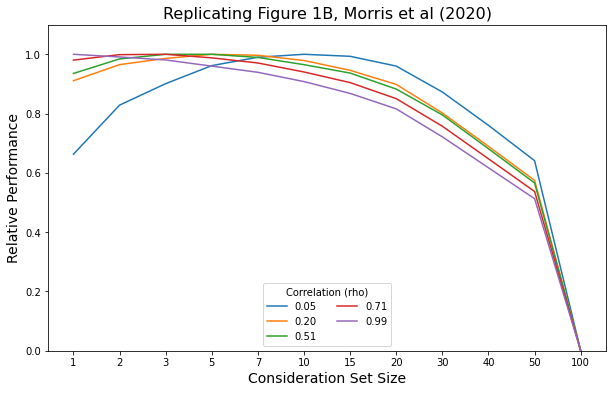

In [227]:
# Replicate Morris et al

data
sigma_taus = [ # rho
    (10, 0.5), # 0.005
    (5, 1), # 0.2
    (5, 3), # 0.51
    (3, 3), # 0.71
    (0.5, 3) # 0.98
]

results = pd.DataFrame()
for sigma, tau in sigma_taus:
    print(sigma_tau_to_rho(sigma, tau))
    results = results.append(data[(data["sigma"]==sigma)&(data["tau"]==tau)&(data["c"]<5)])

to_plot = results.groupby(["agent", "rho"]).agg({"utility": "mean"}).reset_index()
to_plot = to_plot[(to_plot["agent"]!="dynamic")]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim((0.0, 1.1))

for rho in to_plot["rho"].unique():
    subset = to_plot[to_plot["rho"]==rho].copy()
    subset["utility"] += min(subset["utility"]) * ((min(subset["utility"]) <= 0)  * (-1))
    subset["utility"] /= max(subset["utility"])
    subset = subset.assign(agent_numeric=subset["agent"].apply(lambda x: int(x[1:]))).sort_values("agent_numeric")
    plt.plot(subset["agent"].apply(lambda x: str(x[1:])), subset["utility"], label=f"{rho:.2f}")
plt.legend(title="Correlation (rho)", loc="lower center", ncol=2)
plt.title("Replicating Figure 1B, Morris et al (2020)", size=16)
plt.xlabel("Consideration Set Size", size=14)
plt.ylabel("Relative Performance", size=14)
plt.show()

In [171]:
# Dynamic vs static prediction

num_trials = 1000
cost_eval = 0.2
N = 20

env = DecisionEnvironment(N=N, num_trials=num_trials, sigma=1, tau=1)
ddm = DynamicDecisionMaker(env, cost_eval=cost_eval)
ddm.decide()
                
fixed_dm = FixedDecisionMaker(env, 5, cost_eval=cost_eval)
fixed_dm.decide()

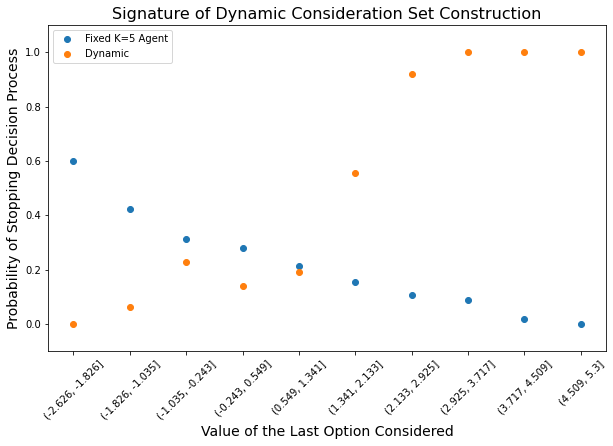

In [177]:
results = fixed_dm.experiment_data
results["agent"] = "Fixed K=5 Agent"
ddm.experiment_data["agent"] = "Dynamic"
results = results.append(ddm.experiment_data)

results["value_bin"] = pd.cut(results["value"], 10)
results["last"] = results["last"].astype(int)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim((-0.1, 1.1))

for agent in results["agent"].unique():

    to_plot = results[results["agent"]==agent].groupby("value_bin").agg({"last": "mean", "order": "count"}).reset_index()
    to_plot["value_bin"] = to_plot["value_bin"].astype(str)

    plt.scatter(to_plot["value_bin"], to_plot["last"], label=agent)
    plt.xticks(rotation=45)
    plt.ylabel("Probability of Stopping Decision Process", size=14)
    plt.xlabel("Value of the Last Option Considered", size=14)

plt.title("Signature of Dynamic Consideration Set Construction", size=16)
plt.legend()
plt.show()

In [238]:
# Equivalently utility of the lass option is higher

data[(data["N"]==20)&(data["sigma"]<=10)&(data["c"]<=5)].groupby("agent").agg({"gross_utility_last_eval": "mean"})

,gross_utility_last_eval
agent,
K1,2.812748
K10,0.118817
K15,-0.902925
K2,2.119547
K20,-2.805138
K3,1.767219
K5,1.058119
K7,0.668295
dynamic,5.957418


In [228]:
# Argue for our choices of c

data[data["agent"]=="dynamic"].groupby(["N", "c"]).agg({"num_eval": "mean"})

num_eval
N   c              
10  0.1    6.264167
    0.2    5.650000
    0.5    4.466667
    1.0    3.838750
    5.0    2.240000
    10.0   1.761250
20  0.1   10.227917
    0.2    8.654583
    0.5    6.641667
    1.0    5.057917
    5.0    2.485000
    10.0   1.780833
50  0.1   17.550417
    0.2   13.824167
    0.5    9.225833
    1.0    6.745833
    5.0    2.569583
    10.0   1.787917
100 0.1   23.982500
    0.2   17.861667
    0.5   10.827917
    1.0    7.154583
    5.0    2.605417
    10.0   1.837083